# <font color=2B3856><span style='font-family:Comic Sans MS'><u>Comparison</u> of Unsupervised Anomaly Detection Methods
### <font color=2B3856><span style='font-family:Comic Sans MS'>(using the credit card fraud dataset)
<span style='font-family:Comic Sans MS'> by Ori Rosenthal

### <span style='font-family:Comic Sans MS'><font color=2B3856>The main purpose of this paper is to compare the approach (interquartile range outlier detection scoring system) I developed and described in a previous article (http://bit.ly/iqrod),<br> with other unsupervised anomaly detection algorithms.


* <font color=1E5FE0><span style='font-family:Comic Sans MS'><b>Interquartile Range Outlier Detection (IQROD) -</b><font color=5E676B> Statistical anomaly detection algorithm scoring system based on interquartile range scoring. 

### <span style='font-family:Comic Sans MS'><font color=2B3856>For that purpose I used the Credit Card Fraud Detection dataset from kaggle,<br>scaled and separate features from the target variable, and test 4 well-known unsupervised algorithmss:    

* <font color=1E5FE0><span style='font-family:Comic Sans MS'><b>Isolation Forest (IFOREST) -</b><font color=5E676B> built on the basis of decision trees, where points that can be isolated from other data are more likely to be anomalies (the shorter the average path, more anomalous the data instance is)

* <font color=1E5FE0><span style='font-family:Comic Sans MS'><b>One-Class Support Vector Machine (OCSVM) -</b><font color=5E676B>  the model estimates the support of a distribution by identifying regions in input space where most of the cases lie. It does this by nonlinearly projecting the data into a feature space, and there separating the data from the origin by as large a margin as possible.

* <font color=1E5FE0><span style='font-family:Comic Sans MS'><b>Histogram-Based Outlier Score (HBOS) -</b><font color=5E676B> statistical anomaly detection algorithm which assumes the feature independence and calculates the outlier score by creating a univariate histogram for each single feature of the dataset.

* <font color=1E5FE0><span style='font-family:Comic Sans MS'><b>K-Nearest Neighbor (KNN) -</b><font color=5E676B> Density Based Anomaly Detection, a method deployed for classification of a datapoint. The way it works is a new datapoint will be compared to a k-number of existing data points to determine how to classify it

In [1]:
import pandas as pd
import numpy as np
from sklearn.svm import OneClassSVM
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import IsolationForest
from sklearn.metrics import confusion_matrix, recall_score
from pyod.models.knn import KNN
from pyod.models.hbos import HBOS
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

### <span style='font-family:Comic Sans MS'>Dataset Content
<span style='font-family:Comic Sans MS'>The datasets contains transactions made by credit cards in September 2013 by european cardholders. This dataset presents transactions that occurred in two days, where we have <b>492</b> frauds out of <b>284,807</b> transactions. The dataset is highly unbalanced, the positive class (frauds) account for <b>0.172%</b> of all transactions.

<span style='font-family:Comic Sans MS'>It contains only numerical input variables which are the result of a PCA transformation.<br>Features V1, V2, ... V28 are the principal components obtained with PCA, the only features which have not been transformed with PCA are 'Time' and 'Amount'. Feature 'Time' contains the seconds elapsed between each transaction and the first transaction in the dataset. The feature 'Amount' is the transaction Amount, this feature can be used for example-dependant cost-senstive learning. Feature 'Class' is the response variable and it takes value 1 in case of fraud and 0 otherwise.

In [2]:
df = pd.read_csv(r'c:/Users/User/creditcard.csv')

In [3]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [4]:
# Min-max scalling & separating features from the target variable
mms = MinMaxScaler()
X = df.drop('Class', axis=1)
y = df['Class']

X = mms.fit_transform(X)

### <span style='font-family:Comic Sans MS'><u>IQROD functions</u>

In [5]:
def iqr_detection (data):
    
    q1,q3 = np.percentile(data, [25,75])
    iqr = q3 - q1
    lower_bound = q1 - (iqr * 1.5)
    upper_bound = q3 + (iqr * 1.5)
    return np.where((data > upper_bound), data,
                    np.where ((data < lower_bound), (1-data), 0)) # Giving the same magnitude to the opposite sides outlier


def iqrod (df, threshold=0.0015):
    
    mms = MinMaxScaler()
    df_iqr = mms.fit_transform(df)
    df_iqr = pd.DataFrame(df_iqr, columns=df.columns)
    df_iqr = df_iqr.drop('Class', axis=1).apply(iqr_detection)    
    df_iqr['total_iqr'] = df_iqr.sum(axis=1)
    df_iqr = pd.concat([df_iqr ,df['Class']], axis=1)
    threshold = int(threshold * len(df))
    df_iqr = df_iqr.sort_values(by='total_iqr', ascending=False).reset_index()
    df_iqr.loc[:threshold, 'iqr_predict'] = 1
    df_iqr.loc[threshold:, 'iqr_predict'] = 0
    df_iqr.set_index('index', inplace=True)
    df_iqr.sort_index(inplace=True)
    
    return df_iqr['iqr_predict'].values # Return algorithm classifier prediction


In [6]:
# Calculate fraud fraction (o_fraction = outlier fraction)
o_fraction = df['Class'].value_counts(normalize=True)[1]

# Build outlier detection algorithms dictionary
classifiers = {
    'IQROD'  : iqrod(df, o_fraction),
    'IFOREST': IsolationForest(contamination=o_fraction),
    'OCSVM'  : OneClassSVM(nu=o_fraction),
    'HBOS'   : HBOS(contamination=o_fraction),
    'KNN'    : KNN(contamination=o_fraction)
   }


<span style='font-family:Comic Sans MS'>because some of the classifiers return their prediction labeled with 1,-1 we should modify for 0,1:

In [7]:
def modify_labels(prediction):
    
    prediction[prediction == 1] = 0
    prediction[prediction == -1] = 1
    return prediction    


### <span style='font-family:Comic Sans MS'><u>Classifiers prediction dictionary></u>

In [8]:
classifiers_prediction=dict()

for name, clf in classifiers.items():
    if name == 'IQROD':
        classifiers_prediction[name] = clf
    elif name == 'IFOREST':
        classifiers_prediction[name] = modify_labels(clf.fit(X).predict(X))
    elif name == 'OCSVM':
        classifiers_prediction[name] = modify_labels(clf.fit(X).predict(X))
    elif name == 'HBOS':
        classifiers_prediction[name] = clf.fit(X).predict(X)
    elif name == 'KNN':
        classifiers_prediction[name] = clf.fit(X).predict(X)    
    
        

..

 <span style='font-family:Comic Sans MS'> Although I didn't use the fraud labels to build the unsupervised fraud detection solutions, <br> I will use the labels to evaluate the results.

### <span style='font-family:Comic Sans MS'>Confusion Matrices

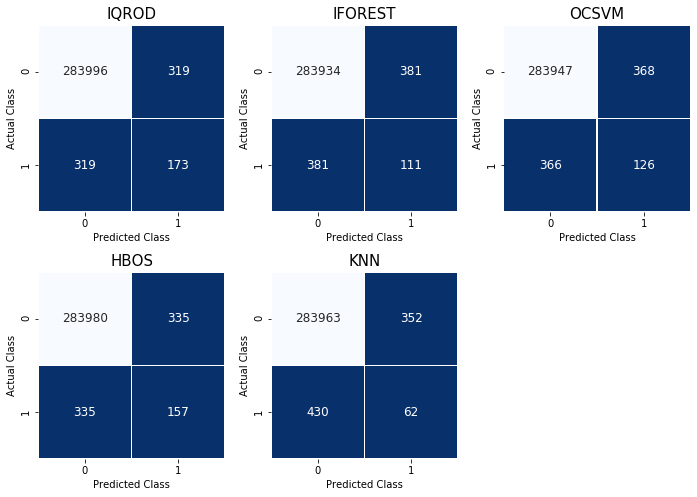

In [9]:
j = 0
plt.figure(figsize=(10,10))
for name, y_pred in classifiers_prediction.items():
   
    
    cm = confusion_matrix(y,y_pred)
    plt.subplot(3,3,j+1)
    sns.heatmap(cm, annot=True, fmt=".0f",linewidths=.5,square = True, cmap ='Blues_r',cbar=False,
                annot_kws={"fontsize":12}); 

    # labels, title and ticks
    plt.ylabel('Actual Class');
    plt.xlabel('Predicted Class');
    plt.title(name, fontsize=15); 
    plt.tight_layout()
    plt.subplots_adjust(top=0.95)
    plt.tight_layout()
    j +=1


<span style='font-family:Comic Sans MS'><b>Recall</b> measures out of all the fraudulent transactions, what percentage of these are correctly identified by our model.<br>
I will put all our classifers results into a DataFrame and sort them.

In [14]:
pd.DataFrame([round(recall_score(y, x),3) for x in classifiers_prediction.values()],
             index=classifiers_prediction.keys(), columns=['Recall score']).sort_values(by='Recall score').\
             style.highlight_max(color='lightgreen')   

,Recall score
KNN,0.126
IFOREST,0.226
OCSVM,0.256
HBOS,0.319
IQROD,0.352


## <span style='font-family:Comic Sans MS'>Conclusion

### <font color=2B3856><span style='font-family:Comic Sans MS'>Although this is a simple comparison test and not a scientific one, the IQROD method shows great promise in comparison with other methods, further research on other data sets and methods needs to be carried out under different conditions for further evaluation.